# Local Search Region Bayesian Optimization

In this notebook the Branin benchmark from paper about local search region BO (https://www.merl.com/publications/docs/TR2023-057.pdf) is reproduced. Note that we use here by purpose `qEI` as acquisition function to reproduce the paper. 

## Imports and helper methods

In [ ]:
import warnings

import pandas as pd

import bofire.strategies.api as strategies
from bofire.benchmarks.api import Branin
from bofire.data_models.acquisition_functions.api import qEI
from bofire.data_models.domain.api import Domain
from bofire.data_models.strategies.api import (
    LSRBO,
    BotorchOptimizer,
    RandomStrategy,
    SoboStrategy,
)
from bofire.runners.api import run


warnings.filterwarnings("ignore")

bench = Branin(locality_factor=0.5)


def sample(domain):
    sampled = domain.inputs.sample(10)
    return sampled
    # sampled = bench.f(sampled, return_complete = True)
    # sampled = sampled.sort_values(by="y", ascending=False, ignore_index=True)
    # return sampled[bench.domain.inputs.get_keys()].copy()


def best(domain: Domain, experiments: pd.DataFrame) -> float:
    return experiments.y.min()

/opt/homebrew/Caskroom/miniforge/base/envs/bofire-2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Random Optimization
Here random sampling is performed without any local search region constraints applied.

In [ ]:
random_results = [
    run(
        Branin(locality_factor=0.5),
        strategy_factory=lambda domain: strategies.map(RandomStrategy(domain=domain)),
        n_iterations=80,
        metric=best,
        initial_sampler=sample,
        n_runs=1,
        n_procs=1,
    )
    for _ in range(5)
]

Run 0: 100%|██████████| 80/80 [00:00<00:00, 233.43it/s, Current Best:=2.942]


## SOBO Optimization
Here standard bayesian optimization is performed without any local search region constraints applied using the qEI acquistion function.

In [ ]:
sobo_results = [
    run(
        Branin(locality_factor=0.5),
        strategy_factory=lambda domain: strategies.map(
            SoboStrategy(domain=domain, acquisition_function=qEI()),
        ),
        n_iterations=80,
        metric=best,
        initial_sampler=sample,
        n_runs=1,
        n_procs=1,
    )
    for _ in range(5)
]

Run 0: 100%|██████████| 80/80 [00:23<00:00,  3.36it/s, Current Best:=0.398]


## Local SOBO Optimization
Here bayesian optimization is performed with setting `gamma` parameter of the LSR-BO method to 0 which results in a pure local optimization with respect to the last random sample.

In [ ]:
local_results = [
    run(
        Branin(locality_factor=0.5),
        strategy_factory=lambda domain: strategies.map(
            SoboStrategy(
                domain=domain,
                acquisition_function=qEI(),
                acquisition_optimizer=BotorchOptimizer(
                    local_search_config=LSRBO(gamma=0)
                ),
            ),
        ),
        n_iterations=80,
        metric=best,
        initial_sampler=sample,
        n_runs=1,
        n_procs=1,
    )
    for _ in range(5)
]

Run 0: 100%|██████████| 80/80 [00:31<00:00,  2.50it/s, Current Best:=0.398]


## Global SOBO Optimization (Projection)
Here bayesian optimization is performed with setting `gamma` parameter of the LSR-BO method to 500 which results in taking always the biggest step in the direction of the global candidate. In the original paper, this is called "Projection".

In [ ]:
global_results = [
    run(
        Branin(locality_factor=0.5),
        strategy_factory=lambda domain: strategies.map(
            SoboStrategy(
                domain=domain,
                acquisition_function=qEI(),
                acquisition_optimizer=BotorchOptimizer(
                    local_search_config=LSRBO(gamma=500)
                ),
            ),
        ),
        n_iterations=80,
        metric=best,
        initial_sampler=sample,
        n_runs=1,
        n_procs=1,
    )
    for _ in range(5)
]

Run 0: 100%|██████████| 80/80 [00:31<00:00,  2.50it/s, Current Best:=0.841]


## LSR-BO
Here the actual method from the paper is performed with setting `gamma` to 0.1.

In [ ]:
lsr_results = [
    run(
        Branin(locality_factor=0.5),
        strategy_factory=lambda domain: strategies.map(
            SoboStrategy(
                domain=domain,
                acquisition_function=qEI(),
                acquisition_optimizer=BotorchOptimizer(
                    local_search_config=LSRBO(gamma=0.1)
                ),
            ),
        ),
        n_iterations=80,
        metric=best,
        initial_sampler=sample,
        n_runs=1,
        n_procs=1,
    )
    for _ in range(5)
]

Run 0: 100%|██████████| 80/80 [00:25<00:00,  3.09it/s, Current Best:=0.402]


## Plot the results

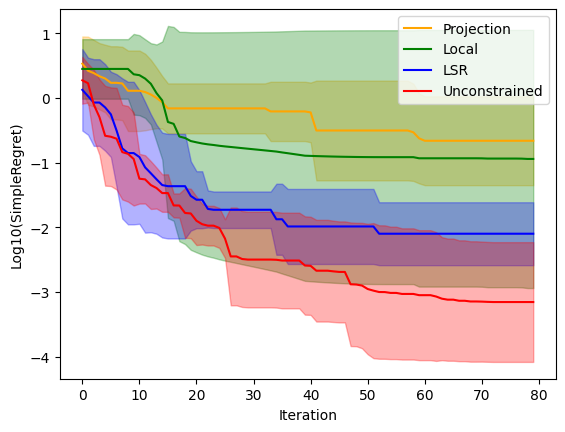

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots()

best_random = np.array([random_results[i][0][1] for i in range(len(random_results))])
ax.plot(range(80), best_random.mean(axis=0), color="gray", label="Random")
ax.fill_between(
    range(80),
    (best_random.mean(0) - best_random.std(0)),
    (best_random.mean(0) + best_random.std(0)),
    alpha=0.3,
    color="gray",
)

best_global = np.log10(
    np.array([global_results[i][0][1] for i in range(len(global_results))]) - 0.397887,
)
ax.plot(range(80), best_global.mean(axis=0), color="orange", label="Projection")
ax.fill_between(
    range(80),
    (best_global.mean(0) - best_global.std(0)),
    (best_global.mean(0) + best_global.std(0)),
    alpha=0.3,
    color="orange",
)

best_local = np.log10(
    np.array([local_results[i][0][1] for i in range(len(global_results))]) - 0.397887,
)
ax.plot(range(80), best_local.mean(axis=0), color="green", label="Local")
ax.fill_between(
    range(80),
    (best_local.mean(0) - best_local.std(0)),
    (best_local.mean(0) + best_local.std(0)),
    alpha=0.3,
    color="green",
)

best_lsr = np.log10(
    np.array([lsr_results[i][0][1] for i in range(len(lsr_results))]) - 0.397887,
)
ax.plot(range(80), best_lsr.mean(axis=0), color="blue", label="LSR")
ax.fill_between(
    range(80),
    (best_lsr.mean(0) - best_lsr.std(0)),
    (best_lsr.mean(0) + best_lsr.std(0)),
    alpha=0.3,
    color="blue",
)

best_unconstrained = np.log10(
    np.array([sobo_results[i][0][1] for i in range(len(sobo_results))]) - 0.397887,
)
ax.plot(range(80), best_unconstrained.mean(axis=0), color="red", label="Unconstrained")
ax.fill_between(
    range(80),
    (best_unconstrained.mean(0) - best_unconstrained.std(0)),
    (best_unconstrained.mean(0) + best_unconstrained.std(0)),
    alpha=0.3,
    color="red",
)


ax.set_xlabel("Iteration")
ax.set_ylabel("Log10(SimpleRegret)")
ax.legend()

plt.show()